In [1]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd

#get the data
split_ratio = 0.8
val_ratio = 0.2
data = pd.read_csv("Data/dataset_multilabel.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

#initialize the data loader 
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True)

In [3]:
#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

#define the model 
device = "cpu"
transformer = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(transformer.parameters())

/Users/rishabhgoel/Environments/Randomness_Testing/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
# train and validate the model
train_losses = []
train_f1 = []
val_losses = []
val_f1 = []
batch_num = []
for epoch in range(3):
    transformer.train()
    for i, data in enumerate(train_loader):
        #get the data
        queues, labels = data
        queues = queues.to(device)
        labels = labels.to(device)

        #forward pass
        optimizer.zero_grad()
        output = transformer(queues)
        loss = criterion(output, labels)

        #backward pass
        loss.backward()
        optimizer.step()

        #metrics
        f_score = F_score(output, labels)
        if (i+1) % 100 == 0:
            print('epoch: {}, batch: {}, loss: {} f1 score:{}'.format(epoch + 1, i + 1, loss.item(), f_score))
            train_losses.append(loss.item())
            train_f1.append(f_score)
            batch_num.append((i + 1) + (epoch - 1) * (600))

            #validate the model
            transformer.eval()
            for i, data in enumerate(val_loader):
                queues, labels = data
                queues = queues.to(device)
                labels = labels.to(device)

                #forward pass
                output = transformer(queues)
                loss = criterion(output, labels)

                #metrics
                f_score = F_score(output, labels)

            val_losses.append(loss.item())
            val_f1.append(f_score)
            
            print('epoch: {}, validation loss: {} validation f1 score:{}'.format(epoch + 1, loss.item(), f_score))
            transformer.train()

epoch: 1, batch: 100, loss: 0.3330458998680115 f1 score:0.816094160079956
epoch: 1, validation loss: 0.32254499197006226 validation f1 score:0.8286112546920776


/var/folders/5m/5bz8j_1n6bv7tpcnz6sjyc280000gn/T/ipykernel_85078/17299761.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
/var/folders/5m/5bz8j_1n6bv7tpcnz6sjyc280000gn/T/ipykernel_85078/17299761.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  g.show()


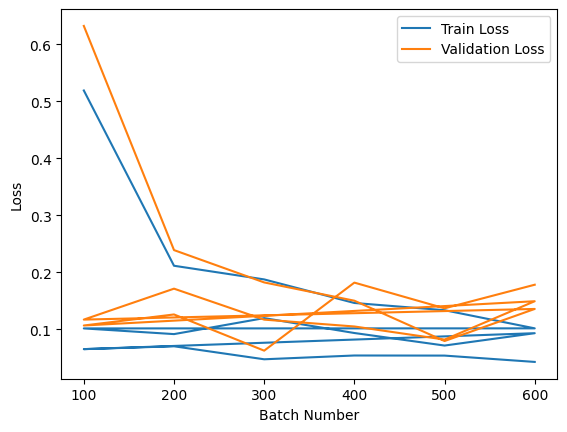

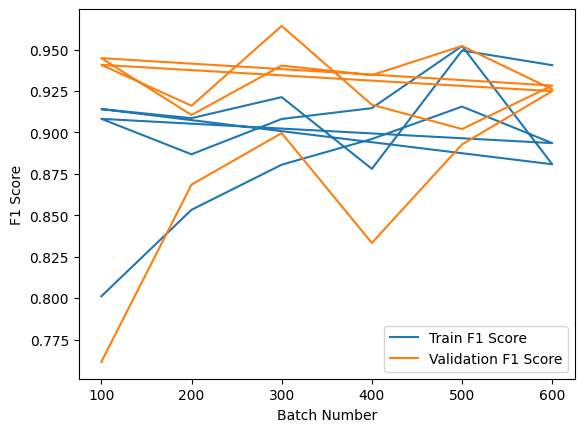

In [67]:
#plot the validation and training loss as well as f1 score
import matplotlib.pyplot as plt

f = plt.figure(1)
plt.plot(batch_num, train_losses, label = "Train Loss")
plt.plot(batch_num, val_losses, label = "Validation Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.legend()
f.show()

g = plt.figure(2)
plt.plot(batch_num, train_f1, label = "Train F1 Score")
plt.plot(batch_num, val_f1, label = "Validation F1 Score")
plt.xlabel("Batch Number")
plt.ylabel("F1 Score")
plt.legend()
g.show()

#save the model
torch.save(transformer.state_dict(), "transformer.pth")